In [1]:
#!/usr/bin/python3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets, linear_model, decomposition, manifold, preprocessing
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, roc_auc_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.model_selection import StratifiedKFold, KFold
import random
from genetic import Genetic

random.seed()
np.random.seed()

In [2]:
#----------------------------------------------------
#function calculate model for set of features (tab)
#----------------------------------------------------
def modelCV(x, y, tab):
    #skf = StratifiedKFold(n_splits=5)
    skf = KFold(n_splits=5)
    result = 0
    accuracy = 0
    for train, test in skf.split(x,y):
        reg = linear_model.LogisticRegression()
        reg.fit(x.iloc[train, tab == 1],y.iloc[train])
        temp_pred = reg.predict(x.iloc[test, tab == 1])
        result += mean_squared_error(y.iloc[test], temp_pred)
        accuracy += accuracy_score(y.iloc[test], temp_pred)
    result /=skf.n_splits
    accuracy /=skf.n_splits
    return result, accuracy


In [3]:
#--------------------------------------------------------------------------------------
#function calculate model for preprocessing algorithm and return parameters of best run
#--------------------------------------------------------------------------------------
def CV(reductor, x, y):
    r_best = [0, float('Inf'), 0]
    for i in range(x.shape[1],0,-1):
        reductor.n_components = i
        r_x = pd.DataFrame(reductor.fit(x,y).transform(x))
        r_error, r_accuracy = modelCV(r_x, y, np.ones(r_x.shape[1]))
        if r_error <= r_best[1]:
            r_best = [i, r_error, r_accuracy]
    return r_best[0], r_best[1], r_best[2]

In [4]:
#load dataset
dataset = datasets.load_breast_cancer()
x = pd.DataFrame(dataset["data"], columns=dataset["feature_names"])
y = pd.Series(dataset["target"])

In [5]:
#scale dataset
sc = preprocessing.StandardScaler()
x = pd.DataFrame(sc.fit_transform(x), columns=dataset["feature_names"])

In [6]:
#list for ploting results
benchmark = []
benchmark_names = []
benchmark_2 = []
benchmark_2_names = []

In [7]:
#-----------------------------------
#model without any feature selection
#-----------------------------------
error, accuracy = modelCV(x,y,np.ones(x.columns.size))
benchmark.append([x.columns.size, error, accuracy])
benchmark_names.append('Without preprocessing')
print('Without preprocessing \nNumber of features %d \nError %.3f \nAccuracy %.3f\n' % (x.columns.size, error, accuracy))

Without preprocessing 
Number of features 30 
Error 0.023 
Accuracy 0.977



In [8]:
#----------------------------------------
#model with Recursive feature elimination
#----------------------------------------
rfe_best = [0, float('Inf'), 0]
reg = linear_model.LogisticRegression()
rfe = RFE(reg)
for i in range(x.shape[1],0,-1):
    rfe.n_features_to_select = i
    fit = rfe.fit(x, y)
    rfe_error, rfe_accuracy = modelCV(x, y, fit.support_)
    if rfe_error <= rfe_best[1]:
        rfe_best = [i, rfe_error, rfe_accuracy]
benchmark.append(rfe_best)
benchmark_names.append('RFE')
print('RFE \nNumber of features %d \nError %.3f \nAccuracy %.3f\n' % (rfe_best[0], rfe_best[1], rfe_best[2]))

RFE 
Number of features 26 
Error 0.018 
Accuracy 0.982



In [9]:
#--------------------------------------------------------------------------------
#model with feature selection on feature importances from Random Forest estimator
#--------------------------------------------------------------------------------
rf = RandomForestRegressor()
rf.fit(x, y)
rf_importance=pd.DataFrame(rf.feature_importances_)
rf_importance[1]=np.arange(x.columns.size)
rf_importance=rf_importance.sort_values(by=0)
rfr_ranking = np.array(rf_importance[1])
rfr_tab = np.ones(x.columns.size)
rfr_best = [0, float('Inf'), 0]
rfr_error, rfr_accuracy = modelCV(x, y, rfr_tab)
for i in range(x.shape[1]-1):
    rfr_tab[rfr_ranking[i]] = 0
    rfr_error, rfr_accuracy = modelCV(x, y, rfr_tab)
    if rfr_error <= rfr_best[1]:
        rfr_best = [x.shape[1]-1-i, rfr_error, rfr_accuracy]
benchmark.append(rfr_best)
benchmark_names.append('RFR')
print('RFR \nNumber of features %d \nError %.3f \nAccuracy %.3f\n' % (rfr_best[0], rfr_best[1], rfr_best[2]))

RFR 
Number of features 21 
Error 0.019 
Accuracy 0.981



In [10]:
#-------------------------------------------------------------------------------------------
#model with dimensionality reduction using Linear Discriminant Analysis (not for regression)
#-------------------------------------------------------------------------------------------
lda = LinearDiscriminantAnalysis()
best = CV(lda,x,y)
benchmark.append(best)
benchmark_names.append('LDA')
print('LDA \nNumber of features %d \nError %.3f \nAccuracy %.3f\n' % best)

LDA 
Number of features 1 
Error 0.025 
Accuracy 0.975



In [11]:
#---------------------------------------------------------
#model with dimensionality reduction using Factor Analysis
#---------------------------------------------------------
fa = decomposition.FactorAnalysis(max_iter=2000)
best = CV(fa,x,y)
benchmark.append(best)
benchmark_names.append('FA')
print('FA \nNumber of features %d \nError %.3f \nAccuracy %.3f\n' % best)

FA 
Number of features 30 
Error 0.026 
Accuracy 0.974



In [12]:
#----------------------------------------------------------------------
#model with dimensionality reduction using Principal component analysis
#----------------------------------------------------------------------
pca = decomposition.PCA()
best = CV(pca,x,y)
benchmark.append(best)
benchmark_names.append('PCA')
print('PCA \nNumber of features %d \nError %.3f \nAccuracy %.3f\n' % best)

PCA 
Number of features 15 
Error 0.023 
Accuracy 0.977



In [13]:
#----------------------------------------------------------------------------------
#model with dimensionality reduction through Isometric Mapping (not for regression)
#----------------------------------------------------------------------------------
iso = manifold.Isomap()
best = CV(iso,x,y)
benchmark.append(best)
benchmark_names.append('Isomap')
print('Isomap \nNumber of features %d \nError %.3f \nAccuracy %.3f\n' % best)

Isomap 
Number of features 7 
Error 0.028 
Accuracy 0.972



In [14]:
#-------------------------------------------------------
#model with feature selection based on genetic algorithm
#-------------------------------------------------------
gen = Genetic( features = x.columns.size, parents = 5, children = 20, mutation_scale = 0.05 )
gen.fit(x, y, 20, modelCV)
benchmark.append((np.count_nonzero(gen.tab[0]), gen.best[-1][0], gen.best[-1][1]))
benchmark_names.append('Genetic algorithm')
print('Genetic algorithm \nNumber of features %d \nError %.3f \nAccuracy %.3f\n' % (np.count_nonzero(gen.tab[0]), gen.best[-1][0], gen.best[-1][1]))

Genetic algorithm 
Number of features 15 
Error 0.016 
Accuracy 0.984



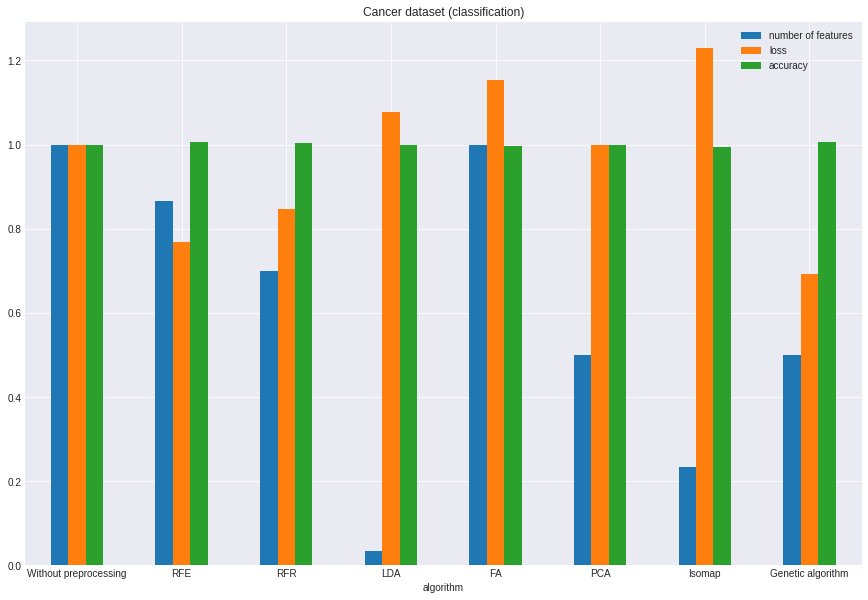

In [20]:
#ploting results normalized to result without feature selection or dimensionality reduction
benchmark = np.array(benchmark)
benchmark /= benchmark[0]
benchmark = pd.DataFrame(benchmark, columns=['number of features','loss','accuracy'])
benchmark['algorithm'] = benchmark_names
benchmark = benchmark.set_index('algorithm')

plt.style.use('seaborn-darkgrid')
benchmark.plot(kind='bar', title='Cancer dataset (classification)', rot=0, figsize=(15,10))

In [21]:
#generate polynomial and interaction features of dataset for creating new features
poly = preprocessing.PolynomialFeatures(2)
x1 = pd.DataFrame(poly.fit_transform(x))

In [22]:
#-----------------------------------
#model with new created features without any feature selection
#-----------------------------------
error, accuracy = modelCV(x1,y,np.ones(x1.columns.size))
benchmark_2.append([x1.columns.size, error, accuracy])
benchmark_2_names.append('Without preprocessing')
print('Without preprocessing with new features\nNumber of features %d \nError %.3f \nAccuracy %.3f\n' % (x1.columns.size, error, accuracy))

#---------------------------------------------------------------------------------
#model with new created features with feature selection based on genetic algorithm
#---------------------------------------------------------------------------------
gen = Genetic( features = x1.columns.size, parents = 5, children = 20, mutation_scale = 0.05 )
gen.fit(x1, y, 20, modelCV)
benchmark_2.append((np.count_nonzero(gen.tab[0]), gen.best[-1][0], gen.best[-1][1]))
benchmark_2_names.append('Genetic algorithm')
print('Genetic algorithm with new features \nNumber of features %d \nError %.3f \nAccuracy %.3f\n' % (np.count_nonzero(gen.tab[0]), gen.best[-1][0], gen.best[-1][1]))

#-------------------------------------------------------------------------------------------------------------------------------
#model with new created features with feature selection based on genetic algorithm with penalty for too many features (constant)
#-------------------------------------------------------------------------------------------------------------------------------
gen = Genetic( features = x1.columns.size, parents = 5, children = 20, mutation_scale = 0.05, regulation_type = 'constant', constant_factor=9*10**-4)
gen.fit(x1, y, 20, modelCV)
benchmark_2.append((np.count_nonzero(gen.tab[0]), gen.best[-1][0], gen.best[-1][1]))
benchmark_2_names.append('Genetic algorithm with regulation(constant)')
print('Genetic algorithm with regulation(constant) with new features \nNumber of features %d \nError %.3f \nAccuracy %.3f\n' % (np.count_nonzero(gen.tab[0]), gen.best[-1][0], gen.best[-1][1]))

#--------------------------------------------------------------------------------------------------------------------------------------
#model with new created features with feature selection based on genetic algorithm with penalty for too many features (percent of loss)
#--------------------------------------------------------------------------------------------------------------------------------------
gen = Genetic( features = x1.columns.size, parents = 5, children = 20, mutation_scale = 0.05, regulation_type = 'percent', percent_factor=9)
gen.fit(x1, y, 20, modelCV)
benchmark_2.append((np.count_nonzero(gen.tab[0]), gen.best[-1][0], gen.best[-1][1]))
benchmark_2_names.append('Genetic algorithm with regulation(percent)')
print('Genetic algorithm with regulation(percent) with new features \nNumber of features %d \nError %.3f \nAccuracy %.3f\n' % (np.count_nonzero(gen.tab[0]), gen.best[-1][0], gen.best[-1][1]))

Without preprocessing with new features
Number of features 496 
Error 0.035 
Accuracy 0.965

Genetic algorithm with new features 
Number of features 141 
Error 0.016 
Accuracy 0.984

Genetic algorithm with regulation(constant) with new features 
Number of features 67 
Error 0.023 
Accuracy 0.977

Genetic algorithm with regulation(percent) with new features 
Number of features 114 
Error 0.012 
Accuracy 0.988



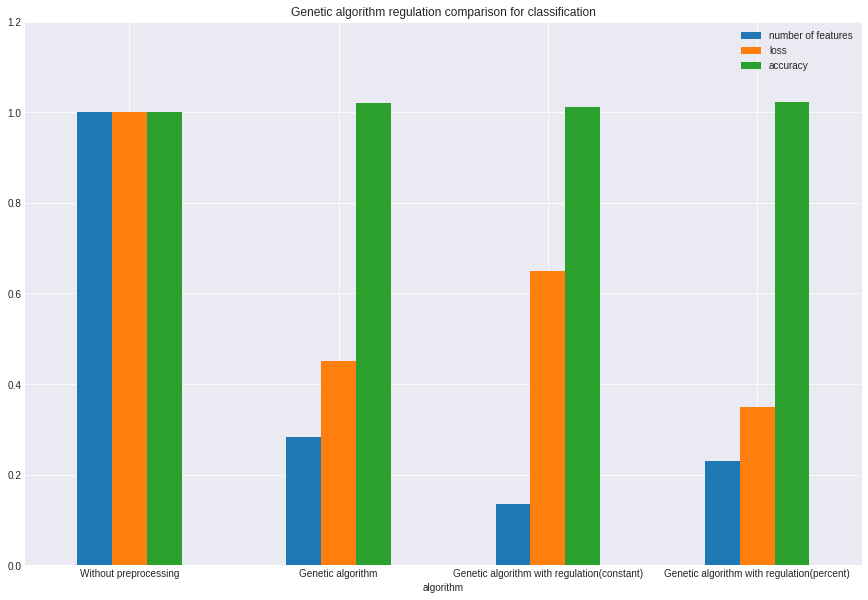

In [24]:
#ploting results normalized to result without feature selection or dimensionality reduction
benchmark_2 = np.array(benchmark_2)
benchmark_2 /= benchmark_2[0]
benchmark_2 = pd.DataFrame(benchmark_2, columns=['number of features','loss','accuracy'])
benchmark_2['algorithm'] = benchmark_2_names
benchmark_2 = benchmark_2.set_index('algorithm')

plt.style.use('seaborn-darkgrid')
benchmark_2.plot(kind='bar', title='Genetic algorithm regulation comparison for classification', rot=0, ylim=[0,1.2], figsize=(15,10))